# Notebook to analyze BirdNET model's results

We ran BirdNET against the recordings at the Kendall Frost Marsh and its results are saved in our NAS server. We now want to analyze the results and visually see its findings

BirdNET results column names:

['Selection', 'View', 'Channel', 'Begin Time (s)', 'End Time (s)', 'Low Freq (Hz)', 'High Freq (Hz)', 'Common Name', 'Species Code', 'Confidence', 'Begin Path', 'File Offset (s)']

In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
from zoneinfo import ZoneInfo

In [3]:
folder_path = '/Volumes/passive-acoustic-biodiversity/kendall-frost-march-2025/BirdNET_baseline_output'
all_files = glob.glob(os.path.join(folder_path, "*.BirdNET.selection.table.txt"))

dfs = []
for file in all_files:
    df = pd.read_csv(file, sep='\t')
    dfs.append(df)

all_data = pd.concat(dfs, ignore_index=True)



In [4]:
# Probably due to corrupted wav files
nocall_count = (all_data['Common Name'] == 'nocall').sum()
print(f"Number of nocall detections: {nocall_count}")

Number of nocall detections: 7


In [5]:
clean_data = all_data[all_data['Common Name'] != 'nocall']
print(f"Number of detections: {clean_data.shape[0]}")

Number of detections: 12348


## Analysis...

In [6]:
# Looking at the number of unique species detected by BirdNET
unique_species = clean_data['Common Name'].unique()
print(f"Number of unique species detected: {len(unique_species)}\n")

Number of unique species detected: 112



In [83]:
# Looking at the Top 10 most freq detected species
top_species = clean_data['Common Name'].value_counts().head(10)
print("Top 10 most frequently detected species:")
print(top_species)

Top 10 most frequently detected species:
Common Name
Royal Tern            1717
Mallard               1407
American Wigeon       1102
Western Gull           962
Savannah Sparrow       931
Green-winged Teal      866
Greater Yellowlegs     501
Least Sandpiper        453
Great Horned Owl       413
Elegant Tern           367
Name: count, dtype: int64


/var/folders/02/sg2pc4k904g27y6yw8zmkmxh0000gn/T/ipykernel_28927/3400372672.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = clean_data_ten.pivot_table(index='conf_bin',


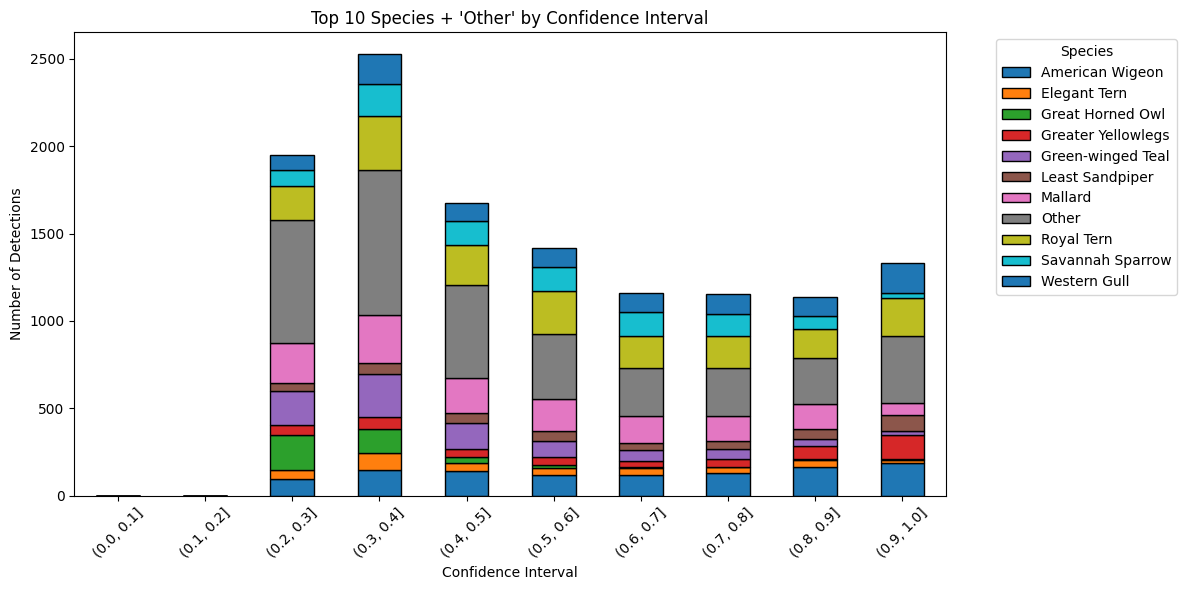

In [103]:
bins = np.arange(0, 1.1, 0.1)
clean_data_ten = clean_data.copy()
clean_data_ten['conf_bin'] = pd.cut(clean_data_ten['Confidence'], bins)

top_species = clean_data_ten['Common Name'].value_counts().head(10).index

clean_data_ten['Species Group'] = clean_data_ten['Common Name'].apply(
    lambda x: x if x in top_species else 'Other'
)

pivot = clean_data_ten.pivot_table(index='conf_bin',
                                columns='Species Group',
                                values='Confidence',
                                aggfunc='count',
                                fill_value=0)

pivot.plot(kind='bar',
           stacked=True,
           figsize=(12, 6),
           edgecolor='black')

plt.title("Top 10 Species + 'Other' by Confidence Interval")
plt.xlabel("Confidence Interval")
plt.ylabel("Number of Detections")
plt.xticks(rotation=45)
plt.legend(title="Species", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/02/sg2pc4k904g27y6yw8zmkmxh0000gn/T/ipykernel_28927/586450858.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = clean_data.pivot_table(index='conf_bin',


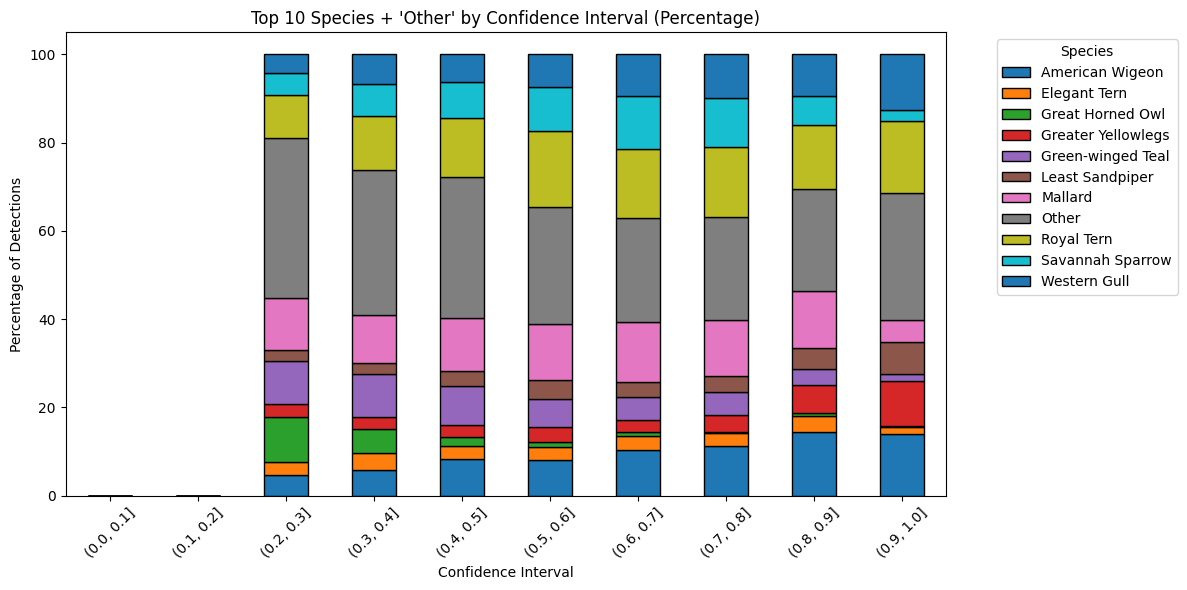

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bins = np.arange(0, 1.1, 0.1)
clean_data = clean_data.copy()
clean_data['conf_bin'] = pd.cut(clean_data['Confidence'], bins)

top_species = clean_data['Common Name'].value_counts().head(10).index

clean_data['Species Group'] = clean_data['Common Name'].apply(
    lambda x: x if x in top_species else 'Other'
)

pivot = clean_data.pivot_table(index='conf_bin',
                                columns='Species Group',
                                values='Confidence',
                                aggfunc='count',
                                fill_value=0)

pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

pivot_pct.plot(kind='bar',
               stacked=True,
               figsize=(12, 6),
               edgecolor='black')

plt.title("Top 10 Species + 'Other' by Confidence Interval (Percentage)")
plt.xlabel("Confidence Interval")
plt.ylabel("Percentage of Detections")
plt.xticks(rotation=45)
plt.legend(title="Species", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [84]:
high_conf_df = clean_data[clean_data['Confidence'] > 0.9]
high_conf_species_counts = high_conf_df['Common Name'].value_counts()
print("Species Detected with their # of high CF detections")
print(high_conf_species_counts.head(10))

Species Detected with their # of high CF detections
Common Name
Royal Tern              217
American Wigeon         187
Western Gull            169
Greater Yellowlegs      135
Least Sandpiper          96
Whimbrel                 71
Mallard                  67
Brant                    58
Black-bellied Plover     47
Savannah Sparrow         32
Name: count, dtype: int64


### Confidence vs # of Unique Species Detected and # of Species Detected

- Number of unique species detected will show the diversity in each confidence interval but can be misleading if one bin has many detections of a few species while another has few detections of many species
- Number of species detected is great for showing the volume of detections 

/var/folders/02/sg2pc4k904g27y6yw8zmkmxh0000gn/T/ipykernel_28927/2295942802.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_species = clean_data.groupby('conf_bin')['Common Name'].nunique()
/var/folders/02/sg2pc4k904g27y6yw8zmkmxh0000gn/T/ipykernel_28927/2295942802.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_detections = clean_data.groupby('conf_bin')['Common Name'].count()


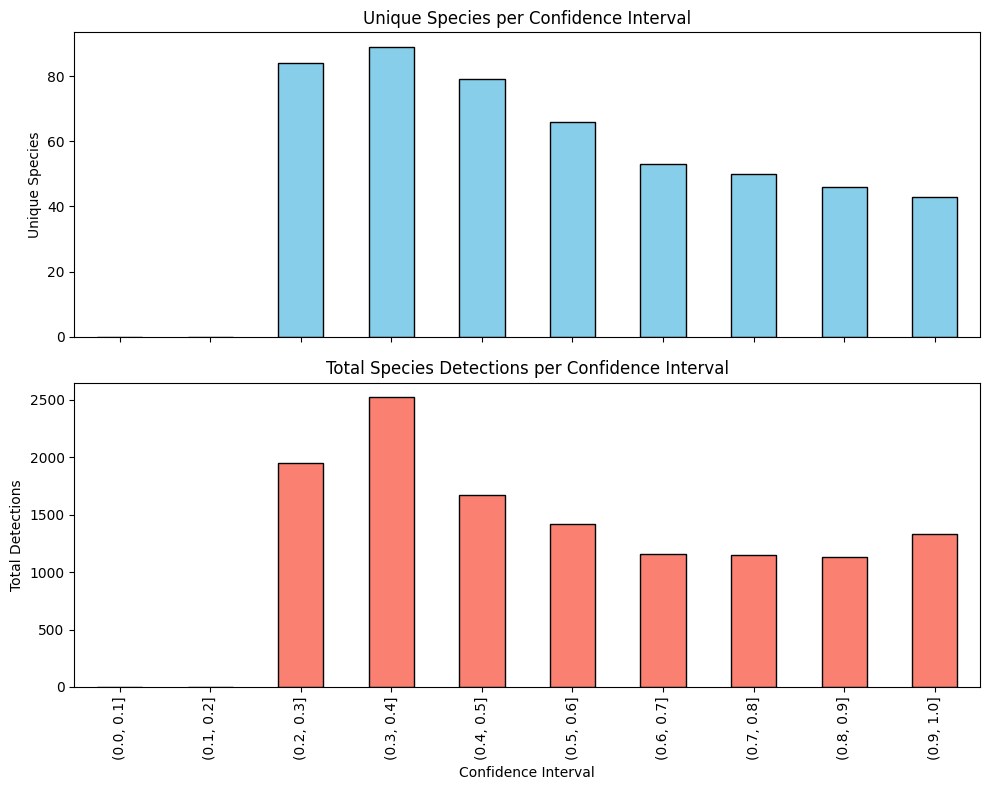

In [85]:
clean_data = clean_data.copy()
bins = np.arange(0, 1.1, 0.1)
clean_data['conf_bin'] = pd.cut(clean_data['Confidence'], bins)

unique_species = clean_data.groupby('conf_bin')['Common Name'].nunique()

total_detections = clean_data.groupby('conf_bin')['Common Name'].count()

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

unique_species.plot(kind='bar', ax=axes[0], edgecolor='black', color='skyblue')
axes[0].set_ylabel("Unique Species")
axes[0].set_title("Unique Species per Confidence Interval")

total_detections.plot(kind='bar', ax=axes[1], edgecolor='black', color='salmon')
axes[1].set_xlabel("Confidence Interval")
axes[1].set_ylabel("Total Detections")
axes[1].set_title("Total Species Detections per Confidence Interval")

plt.tight_layout()
plt.show()

/var/folders/02/sg2pc4k904g27y6yw8zmkmxh0000gn/T/ipykernel_28927/3439452681.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_groups = clean_data.groupby('conf_bin')
/var/folders/02/sg2pc4k904g27y6yw8zmkmxh0000gn/T/ipykernel_28927/3439452681.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


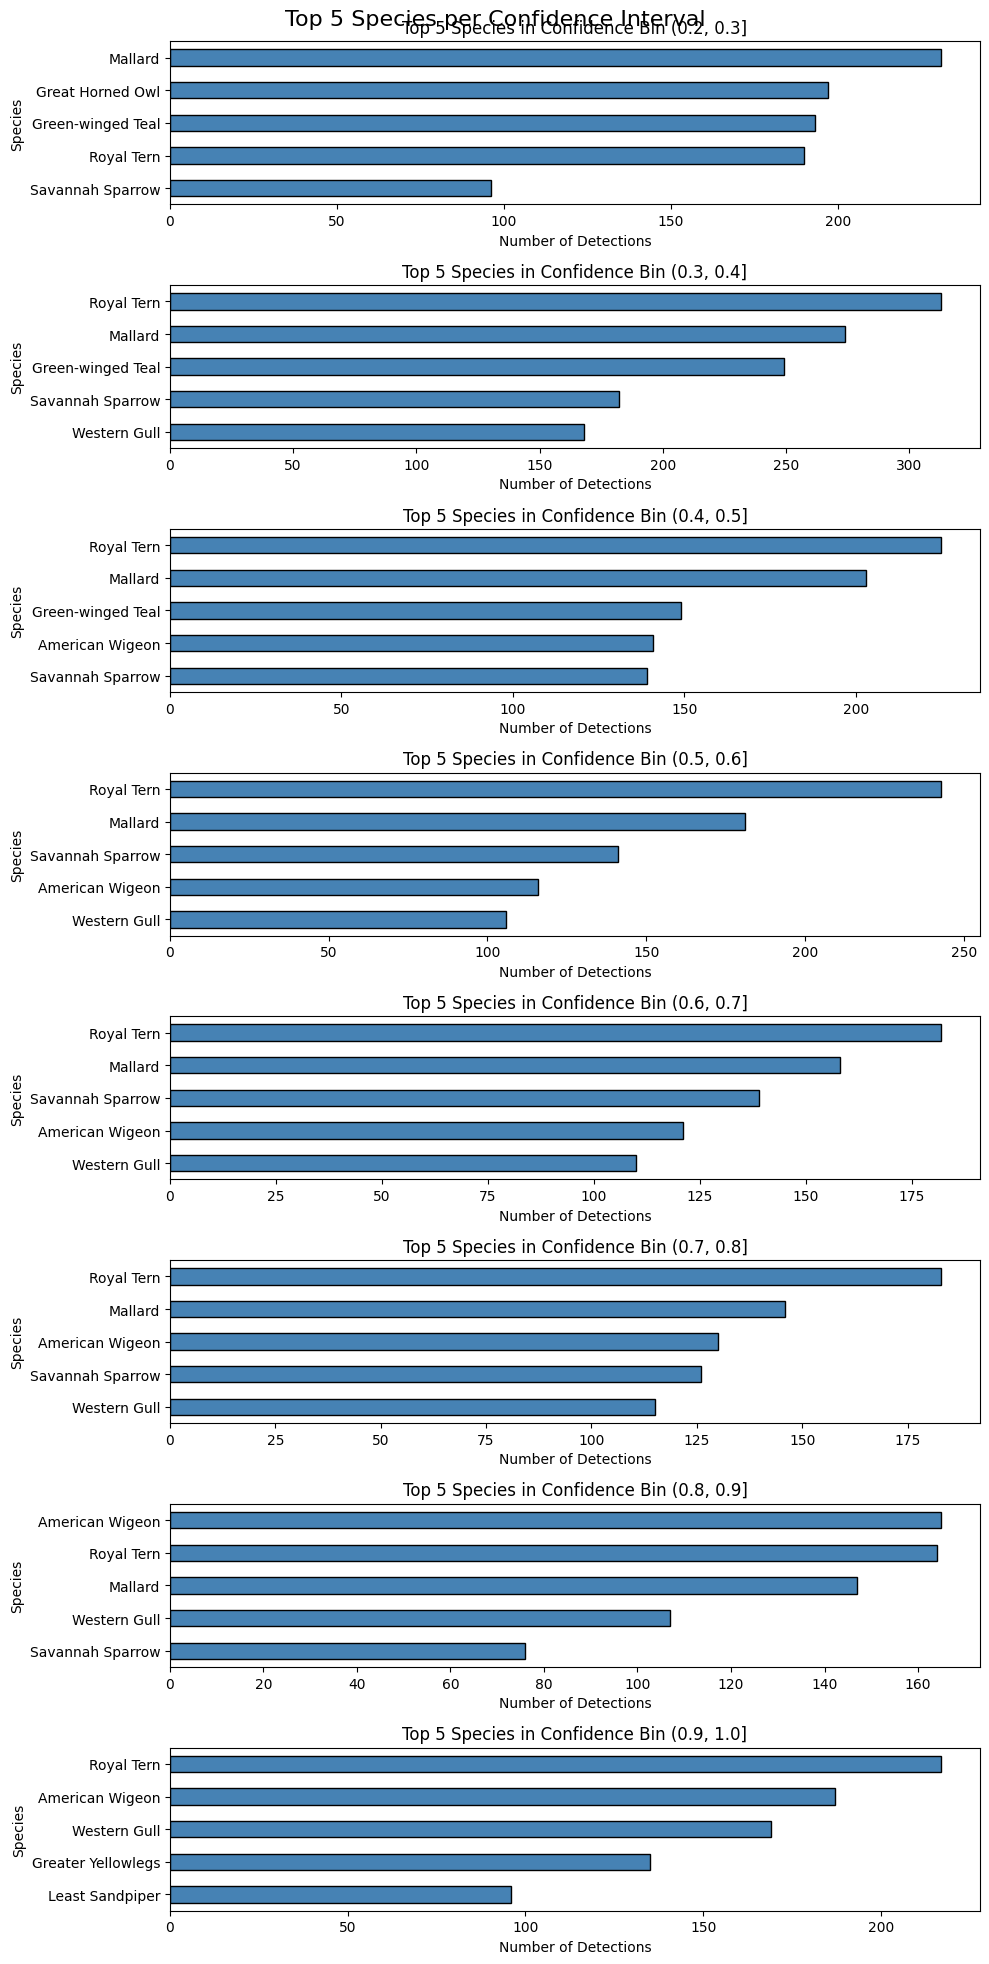

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bins = np.arange(0, 1.1, 0.1)
clean_data = clean_data.copy()
clean_data['conf_bin'] = pd.cut(clean_data['Confidence'], bins)

bin_groups = clean_data.groupby('conf_bin')
valid_bins = [bin for bin, group in bin_groups if not group.empty]

num_bins = len(valid_bins)
fig, axes = plt.subplots(nrows=num_bins, figsize=(10, 2.5 * num_bins), constrained_layout=True)

if num_bins == 1:
    axes = [axes]

for ax, conf_bin in zip(axes, valid_bins):
    group = bin_groups.get_group(conf_bin)
    top_species = group['Common Name'].value_counts().head(5)
    
    top_species[::-1].plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
    ax.set_title(f"Top 5 Species in Confidence Bin {conf_bin}")
    ax.set_xlabel("Number of Detections")
    ax.set_ylabel("Species")

plt.suptitle("Top 5 Species per Confidence Interval", fontsize=16)
plt.tight_layout()
plt.show()


In [87]:
species_excel_path = "/Users/wesleywu/Downloads/kfm-birds.xlsx"
KF_species = pd.read_excel(species_excel_path)
KF_species.dropna(inplace=True)

birdnet_species = set((clean_data['Common Name'].str.strip().str.lower()).unique())
kf_species = set((KF_species['Common Name'].str.strip().str.lower()).unique())

matched_species = birdnet_species.intersection(kf_species)
num_matched = len(matched_species)
print(f"Total unique species detected by BirdNET: {len(birdnet_species)}")
print(f"Number of matches with KF species list: {num_matched}")
# print(f"Matched species:\n{sorted(matched_species)}")

unmatched_species = birdnet_species - kf_species
print(f"Species detected by BirdNET but not in KF list: {len(unmatched_species)}")
print(sorted(unmatched_species))



Total unique species detected by BirdNET: 112
Number of matches with KF species list: 81
Species detected by BirdNET but not in KF list: 31
['acorn woodpecker', "bell's sparrow", 'black-crowned night-heron', 'black-tailed gnatcatcher', 'blue-winged teal', "bonaparte's gull", "brewer's sparrow", 'brown booby', 'cactus wren', 'california quail', 'canada goose', 'canyon wren', 'eurasian collared-dove', "gambel's quail", 'hairy woodpecker', 'loggerhead shrike', 'northern cardinal', 'phainopepla', 'pine siskin', 'prairie falcon', 'purple finch', 'pygmy nuthatch', 'red-breasted nuthatch', 'red-throated loon', 'ring-necked duck', 'rock wren', 'sora', 'surfbird', 'verdin', 'white-breasted nuthatch', 'wrentit']


### Species found by BirdNET but not in the KF list
- 31 species

['acorn woodpecker', "bell's sparrow", 'black-crowned night-heron', 'black-tailed gnatcatcher', 'blue-winged teal', "bonaparte's gull", "brewer's sparrow", 'brown booby', 'cactus wren', 'california quail', 'canada goose', 'canyon wren', 'eurasian collared-dove', "gambel's quail", 'hairy woodpecker', 'loggerhead shrike', 'northern cardinal', 'phainopepla', 'pine siskin', 'prairie falcon', 'purple finch', 'pygmy nuthatch', 'red-breasted nuthatch', 'red-throated loon', 'ring-necked duck', 'rock wren', 'sora', 'surfbird', 'verdin', 'white-breasted nuthatch', 'wrentit']

# Detections vs Time of Day

Rows dropped due to missing 'Hour': 0


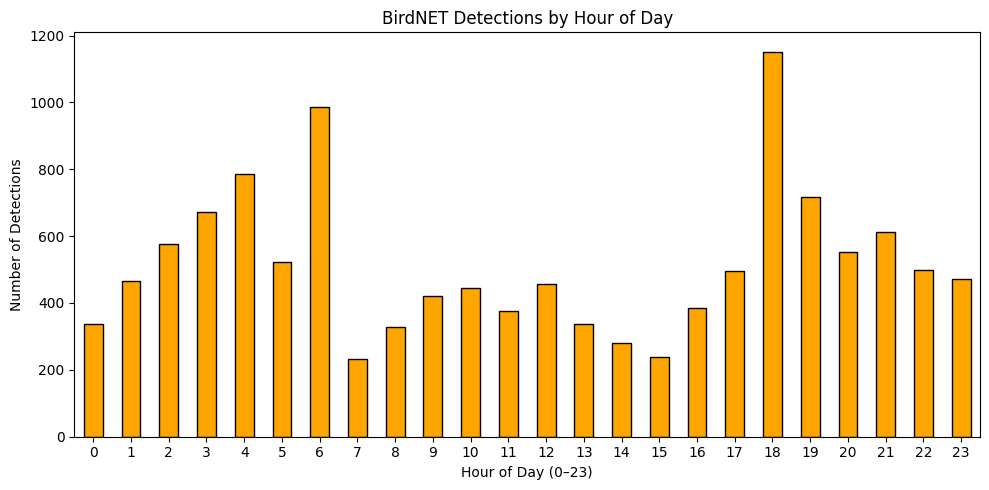

In [93]:
def get_start_time(filename):
    try:
        base = filename.split('/')[-1].split('.')[0]
        date_part, time_part = base.split('_')
        date_str = date_part + time_part
        return datetime.strptime(date_str, "%Y%m%d%H%M%S")
    except Exception as e:
        print(f"Filename parsing failed for: {filename} — {e}")
        return None

def compute_detection_hour(row):
    try:
        start_time = get_start_time(row['Begin Path'])
        offset = timedelta(seconds=row['File Offset (s)'])
        detection_time = start_time + offset
        return detection_time.hour
    except Exception as e:
        print(f"Hour computation failed for row: {row['Begin Path']} — {e}")
        return None

clean_data_2 = clean_data.copy()

clean_data_2['Hour'] = clean_data_2.apply(compute_detection_hour, axis=1)

before_drop = len(clean_data_2)

clean_data_2 = clean_data_2.dropna(subset=['Hour'])

after_drop = len(clean_data_2)

num_dropped = before_drop - after_drop
print(f"Rows dropped due to missing 'Hour': {num_dropped}")

clean_data_2['Hour'] = clean_data_2['Hour'].astype(int)

hourly_counts = clean_data_2['Hour'].value_counts().sort_index()

hourly_counts.plot(kind='bar', figsize=(10, 5), color='orange', edgecolor='black')
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Detections")
plt.title("BirdNET Detections by Hour of Day")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


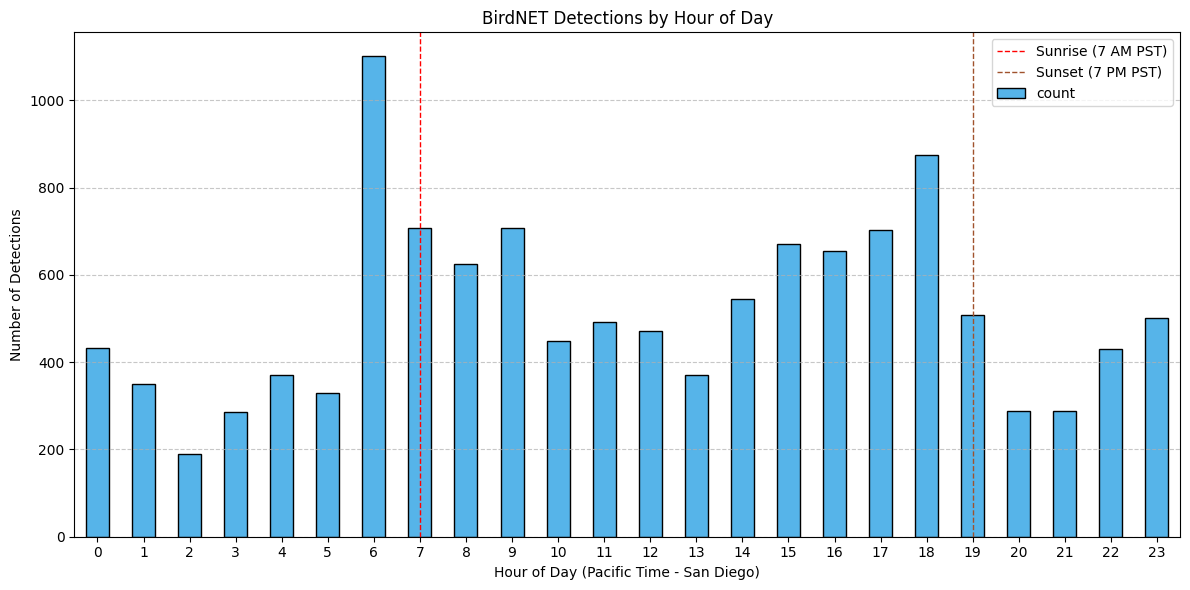

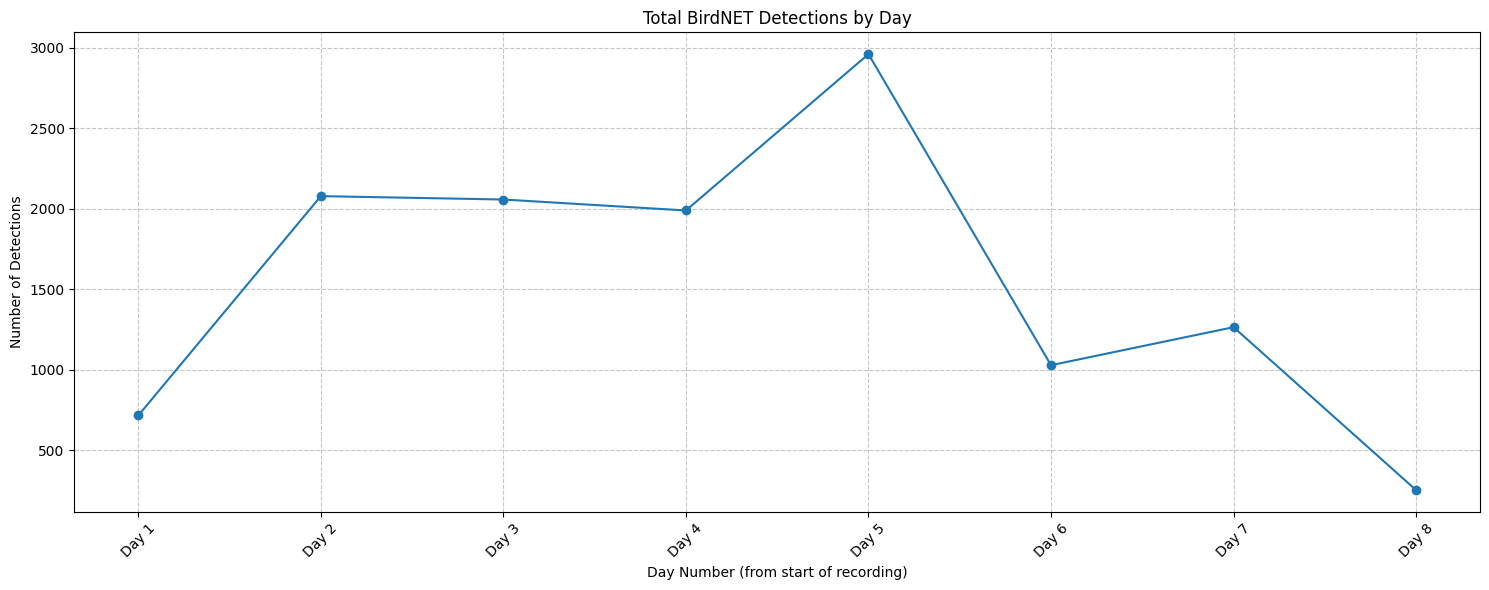

Day 1 → 2025-03-08
Day 2 → 2025-03-09
Day 3 → 2025-03-10
Day 4 → 2025-03-11
Day 5 → 2025-03-12
Day 6 → 2025-03-13
Day 7 → 2025-03-14
Day 8 → 2025-03-15


In [41]:
import pandas as pd
from datetime import datetime, timedelta, date, time
import matplotlib.pyplot as plt
import pytz


def get_naive_start_time(filename):
  try:
    base = filename.split('/')[-1].split('.')[0]
    date_part, time_part = base.split('_')
    date_str = date_part + time_part
    return datetime.strptime(date_str, '%Y%m%d%H%M%S')
  except Exception as e:
    print(f'Filename parsing failed for: {filename} — {e}')
    return None


def map_1970_to_2025_adjusted(
    year, month, day, hour, minute, second, is_hydromoth=False
):

  if year == 1970:
    start_date_2025 = datetime(2025, 3, 8, 11, 30, 0, tzinfo=pytz.timezone('America/Los_Angeles'))  
    start_date_1970_audiomoth = datetime(1970, 1, 1, 0, 0, 9) 
    start_date_1970_hydromoth = datetime(1970, 1, 1, 0, 1, 9)

    if is_hydromoth:
        delta = datetime(year, month, day, hour, minute, second) - start_date_1970_hydromoth
    else:
        delta = datetime(year, month, day, hour, minute, second) - start_date_1970_audiomoth

    mapped_datetime = start_date_2025 + delta
    return mapped_datetime
  return datetime(year, month, day, hour, minute, second)


def compute_detection_datetime_pacific_adjusted(
    row, column_name_for_path='Begin Path', column_name_for_offset='File Offset (s)'
):
  try:
    naive_start_time = get_naive_start_time(row[column_name_for_path])
    if naive_start_time is None:
      return None

    is_hydromoth = 'hydromoth' in row[column_name_for_path].lower()

    correct_datetime_pacific = map_1970_to_2025_adjusted(
        naive_start_time.year,
        naive_start_time.month,
        naive_start_time.day,
        naive_start_time.hour,
        naive_start_time.minute,
        naive_start_time.second,
        is_hydromoth=is_hydromoth,
    )

    offset_seconds = row[column_name_for_offset]
    utc_detection_time = correct_datetime_pacific.astimezone(pytz.utc) + timedelta(
        seconds=offset_seconds
    )
    pacific_tz = pytz.timezone('America/Los_Angeles')
    pacific_detection_datetime = utc_detection_time.astimezone(pacific_tz)
    return pacific_detection_datetime
  except Exception as e:
    print(
        f'Pacific datetime computation failed for row: {row.get(column_name_for_path, "N/A")} — {e}'
    )
    return None

clean_data_pacific = clean_data.copy()

clean_data_pacific['DateTime_Pacific'] = clean_data_pacific.apply(
    compute_detection_datetime_pacific_adjusted, axis=1
)

clean_data_pacific = clean_data_pacific.dropna(subset=['DateTime_Pacific'])

if not clean_data_pacific.empty:
  clean_data_pacific['Hour_Pacific'] = clean_data_pacific[
      'DateTime_Pacific'
  ].dt.hour
  clean_data_pacific['Date_Pacific'] = clean_data_pacific[
      'DateTime_Pacific'
  ].dt.date

  hourly_counts_pacific = (
      clean_data_pacific['Hour_Pacific'].value_counts().sort_index()
  )

  daily_counts_pacific = (
      clean_data_pacific['Date_Pacific'].value_counts().sort_index()
  )

  plt.figure(figsize=(12, 6))
  hourly_counts_pacific.plot(
      kind='bar', color="#56B4E9", edgecolor='black', label='count'
  )
  plt.xlabel('Hour of Day (Pacific Time - San Diego)')
  plt.ylabel('Number of Detections')
  plt.title('BirdNET Detections by Hour of Day')
  plt.xticks(ticks=range(0, 24), labels=[str(i) for i in range(0, 24)], rotation=0)
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  plt.axvline(x=7, color="#FF0000", linestyle='--', linewidth=1, label='Sunrise (7 AM PST)') 
  plt.axvline(x=19, color="#A0522D", linestyle='--', linewidth=1, label='Sunset (7 PM PST)')  

  plt.legend()
  plt.tight_layout()
  plt.show()

daily_counts_pacific = daily_counts_pacific.sort_index()
day_numbers = list(range(1, len(daily_counts_pacific) + 1))

plt.figure(figsize=(15, 6))
plt.plot(
    day_numbers,
    daily_counts_pacific.values,
    marker='o'
)
plt.xlabel('Day Number (from start of recording)')
plt.ylabel('Number of Detections')
plt.title('Total BirdNET Detections by Day')
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(
    day_numbers,
    [f'Day {i}' for i in day_numbers],
    rotation=45
)

plt.tight_layout()
plt.show()


# Audiomoth vs Hydromoth

Total detections per device:
Device
AudioMoth    10220
HydroMoth     2128
Name: count, dtype: int64

Unique species detected per device:
Device
AudioMoth    107
HydroMoth     61
Name: Common Name, dtype: int64


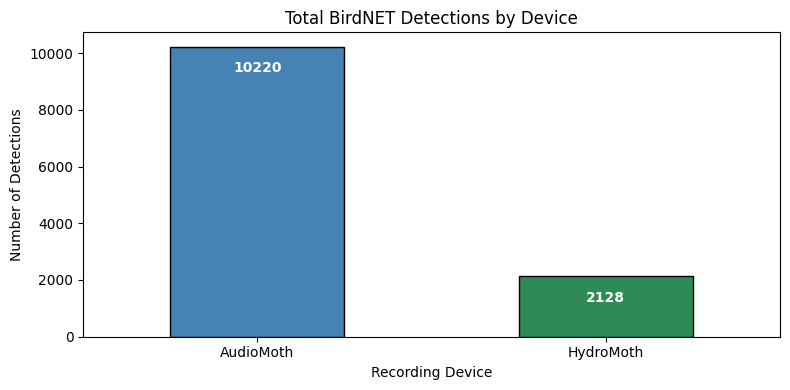

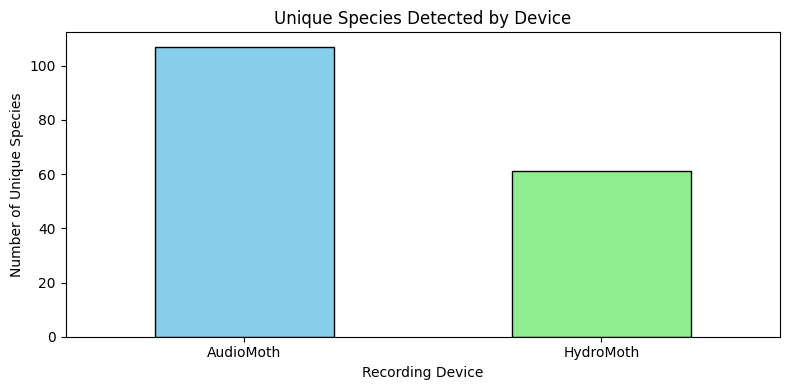


Species detected by both devices: 56
Species only detected by AudioMoth: 51
Species only detected by HydroMoth: 5

Shared species:
 ['Acorn Woodpecker', 'American Avocet', 'American Crow', 'American Pipit', 'American Wigeon', "Anna's Hummingbird", 'Ash-throated Flycatcher', 'Barn Owl', 'Belted Kingfisher', 'Black Skimmer', 'Black-bellied Plover', 'Black-crowned Night-Heron', 'Black-necked Stilt', 'Brant', 'Cactus Wren', 'California Quail', 'Canada Goose', 'Canyon Wren', 'Caspian Tern', 'Common Loon', 'Dunlin', 'Elegant Tern', 'Eurasian Collared-Dove', 'Gadwall', "Gambel's Quail", 'Great Horned Owl', 'Greater Yellowlegs', 'Green-winged Teal', 'Hairy Woodpecker', 'Herring Gull', 'Horned Lark', 'House Finch', 'Killdeer', 'Least Sandpiper', 'Long-billed Curlew', 'Mallard', 'Marbled Godwit', 'Mourning Dove', 'Northern Rough-winged Swallow', 'Osprey', 'Peregrine Falcon', 'Red-breasted Nuthatch', 'Red-shouldered Hawk', 'Ring-billed Gull', 'Rock Wren', 'Royal Tern', 'Savannah Sparrow', "Say's

In [44]:
def identify_device(path):
    path = str(path).lower()
    if 'audiomoth' in path:
        return 'AudioMoth'
    elif 'hydromoth' in path:
        return 'HydroMoth'
    else:
        return 'Unknown'

clean_data_device = clean_data.copy()
clean_data_device['Device'] = clean_data_device['Begin Path'].apply(identify_device)

device_counts = clean_data_device['Device'].value_counts()
print("Total detections per device:")
print(device_counts)

species_by_device = clean_data_device.groupby('Device')['Common Name'].nunique()
print("\nUnique species detected per device:")
print(species_by_device)

plt.figure(figsize=(8, 4))
ax = device_counts.plot(kind='bar', color=['steelblue', 'seagreen'], edgecolor='black')

for i, count in enumerate(device_counts):
    ax.text(i, count - 0.05 * max(device_counts), str(count), 
            ha='center', va='top', color='white', fontsize=10, fontweight='bold')

plt.title("Total BirdNET Detections by Device")
plt.ylabel("Number of Detections")
plt.xlabel("Recording Device")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 4))
species_by_device.plot(kind='bar', color=['skyblue', 'lightgreen'], edgecolor='black')
plt.title("Unique Species Detected by Device")
plt.ylabel("Number of Unique Species")
plt.xlabel("Recording Device")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

audiomoth_species = set(clean_data_device[clean_data_device['Device'] == 'AudioMoth']['Common Name'].unique())
hydromoth_species = set(clean_data_device[clean_data_device['Device'] == 'HydroMoth']['Common Name'].unique())

shared_species = audiomoth_species & hydromoth_species
unique_to_audiomoth = audiomoth_species - hydromoth_species
unique_to_hydromoth = hydromoth_species - audiomoth_species

print("\nSpecies detected by both devices:", len(shared_species))
print("Species only detected by AudioMoth:", len(unique_to_audiomoth))
print("Species only detected by HydroMoth:", len(unique_to_hydromoth))

print("\nShared species:\n", sorted(shared_species))
print("\nUnique to AudioMoth:\n", sorted(unique_to_audiomoth))
print("\nUnique to HydroMoth:\n", sorted(unique_to_hydromoth))
